In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import glob
import os

import advanced_lane_finding

%matplotlib inline

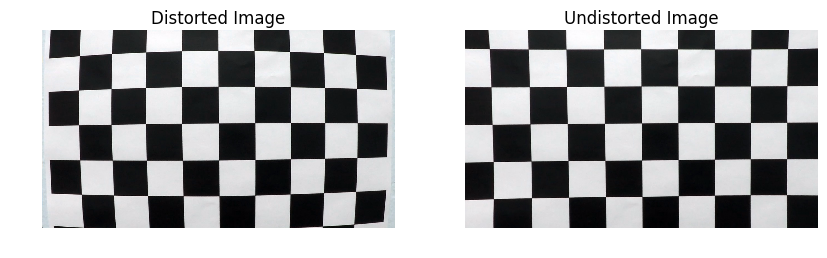

In [2]:
# Camera calibration 
calibration_images = glob.glob('../camera_cal/calibration*.jpg')
calibrator = advanced_lane_finding.CameraCalibrator(calibration_images,
                                                   9, 6,
                                                   use_existing_camera_coefficients = True)

# Take example distorted image and undistort it using saved camera coefficients
distorted_image = '../camera_cal/calibration1.jpg'
distorted_image = cv2.imread(distorted_image)
undistorted_image = calibrator.undistort(distorted_image)

# Display both distorted and undistorted images
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Distorted Image')
plt.imshow(distorted_image)


plt.subplot(1, 2, 2)
plt.imshow(undistorted_image)
plt.axis('off')
plt.title('Undistorted Image')

plt.show()

In [3]:
# Distortion correction looks OK, 
# now I’m going to save all undistorted images to 
# ./output_images/undistorted folder

UNDISTORTED_DEST_LOCATION = '../output_images/camera_cal/'

calibration_images = glob.glob('../camera_cal/calibration*.jpg')

for image in calibration_images:
    start = image.rindex('/') + 1
    end = image.rindex('.')
    dest_path = UNDISTORTED_DEST_LOCATION + image[start:end] + '.jpg'
    
    image = cv2.imread(image)
    undistorted_image = calibrator.undistort(image)
    # Save undistorted image
    cv2.imwrite(dest_path, undistorted_image)

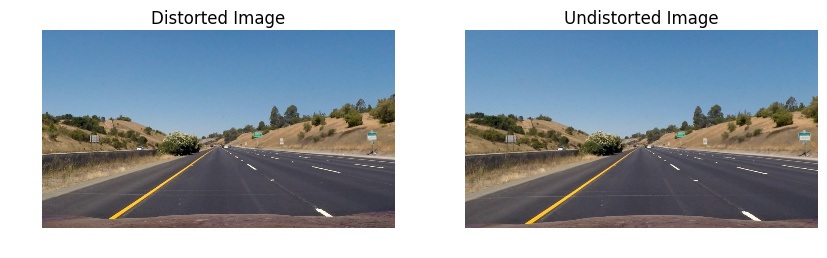

In [4]:
# Next, we are going to apply distortion correction to testing images

sample_image = '../test_images/straight_lines1.jpg'
sample_image = cv2.imread(sample_image)
straight = calibrator.undistort(sample_image)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title('Distorted Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(straight, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')
plt.axis('off')

plt.show()

In [5]:
# Next we are going to save distrotion corrected images to 
# ./output_images/test_images_ undistorted folder

UNDIST_IMAGES_LOCATION = '../output_images/undistorted_test_images/'
TEST_IMAGES_LOCATION = '../test_images/'
images_loc = os.listdir(TEST_IMAGES_LOCATION)

for image_loc in images_loc:
    corred_image_file = UNDIST_IMAGES_LOCATION + image_loc
    distorted_image_location = TEST_IMAGES_LOCATION + image_loc
    distorted_image_location = cv2.imread(distorted_image_location)
    corrected_image = calibrator.undistort(distorted_image_location)
    cv2.imwrite(corred_image_file, corrected_image)

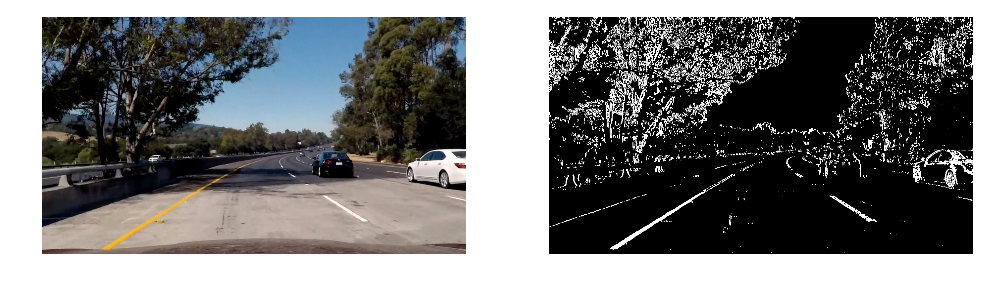

In [6]:
# Now we are ready to do color thresholding and masking 
# in order to find out binary images with lane lines.
saved_undistorted_img = mpimg.imread('../output_images/undistorted_test_images/test5.jpg')
binary_img = advanced_lane_finding.image_binarize(saved_undistorted_img,
                                                 gray_thresh = (20, 255), 
                                                 s_thresh = (150, 255), 
                                                 l_thresh = (120, 255))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(saved_undistorted_img)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(binary_img)

plt.show()

In [7]:
# Next we are going to save all binary threshold image to
# ./output_images/test_images_binary folder

OUTPUT_DIR = '../output_images/test_images_binary/'
INPUT_DIR = '../output_images/undistorted_test_images/'

for file in os.listdir(INPUT_DIR):
    saved_undistorted_img = mpimg.imread(INPUT_DIR + file)
    binary_img = advanced_lane_finding.image_binarize(saved_undistorted_img,
                                                 gray_thresh = (20, 255), 
                                                 s_thresh = (150, 255), 
                                                 l_thresh = (120, 255))
    cv2.imwrite(OUTPUT_DIR + file, binary_img)
print('{} images saved to {} directory'.format(len(os.listdir(INPUT_DIR)),
                                              OUTPUT_DIR))

8 images saved to ../output_images/test_images_binary/ directory


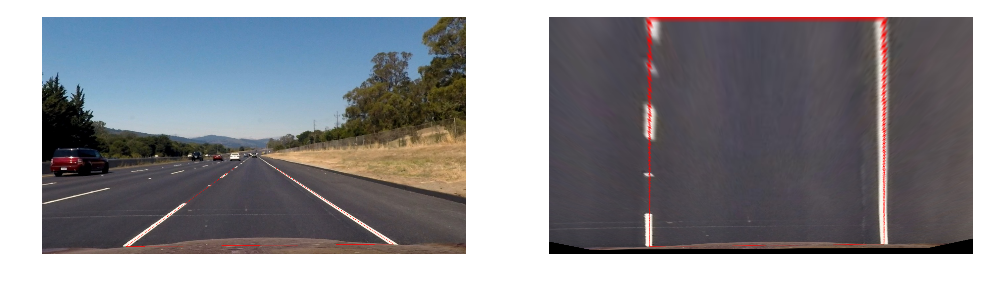

In [8]:
image = mpimg.imread('../output_images/undistorted_test_images/straight_lines2.jpg')

corners = np.float32([[253, 697],[585,456],[700, 456],[1061,690]])
#corners = np.float32([[253, 697],[598,448],[686, 448],[1061,690]])
#corners = np.float32([[253, 697],[573,464],[712, 464],[1061,690]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]

img_size = (image.shape[1], image.shape[0])
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])

perspective = advanced_lane_finding.PerspectiveTransformer(src, dst)


cv2.line(image, (253, 697), (585,456), color=[255,0,0], thickness=1)
cv2.line(image, (585,456), (700, 456), color=[255,0,0], thickness=1)
cv2.line(image, (700, 456), (1061,690), color=[255,0,0], thickness=1)
cv2.line(image, (1061,690), (253, 697), color=[255,0,0], thickness=1)

warped_img = perspective.transform(image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image)


plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(warped_img)

plt.show()

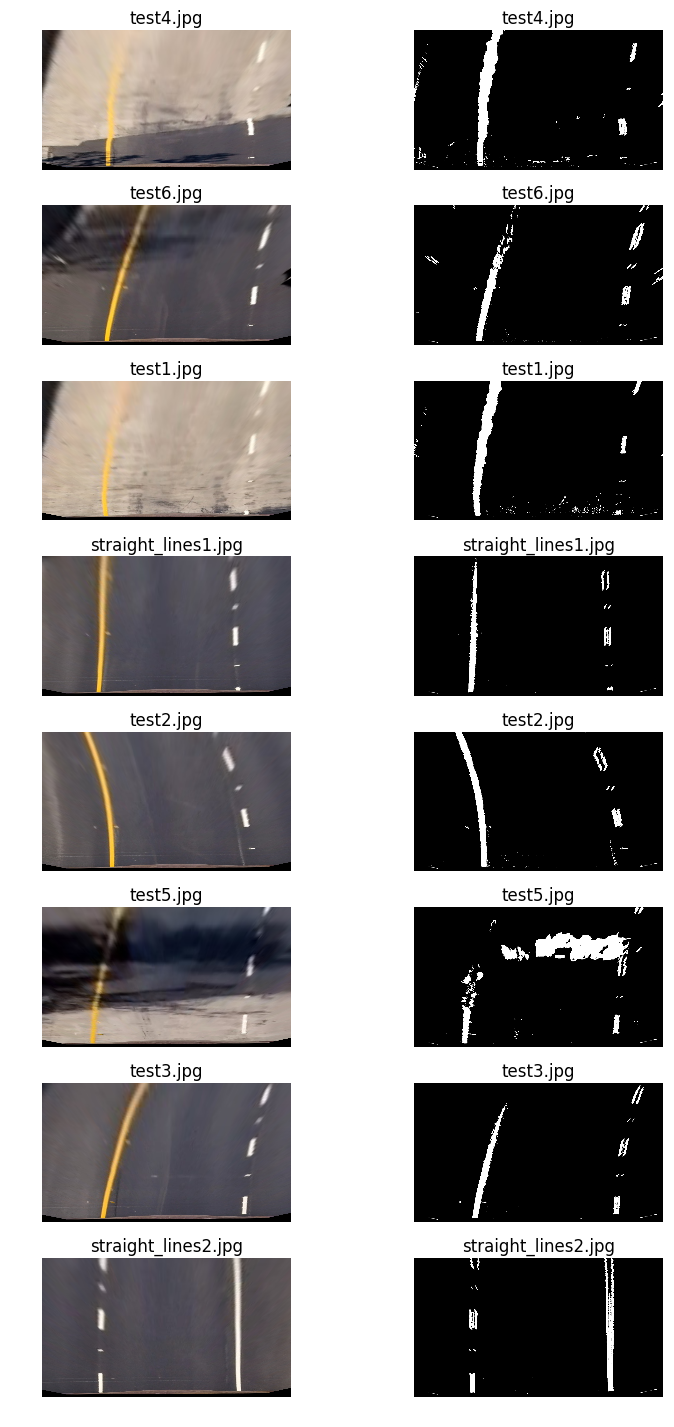

In [9]:
#undistorted = mpimg.imread('../output_images/undistorted_test_images/test5.jpg')

index = 0
plt.figure(figsize=(8, 18))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.5, hspace=0.05)

for file in os.listdir('../output_images/undistorted_test_images/'):
    image = mpimg.imread('../output_images/undistorted_test_images/' + file)
    #print('../output_images/undistorted_test_images/' + file)
    
    ax1 = plt.subplot(gs[index])
    undistorted = perspective.transform(image)
    ax1.axis('off')
    ax1.set_title(file)
    ax1.imshow(undistorted)
    
    index += 1
    
    binary_img = advanced_lane_finding.image_binarize(undistorted,
                                                 gray_thresh = (30, 255), 
                                                 s_thresh = (120, 255), 
                                                 l_thresh = (20, 255))
    #print(binary_img.shape)
    ax2 = plt.subplot(gs[index])
    ax2.axis('off')
    ax2.set_title(file)
    ax2.imshow(binary_img)
    
    index += 1

plt.show()

In [10]:
def extract_laneline_data(src_image, gray_thresh, s_thresh, l_thresh):   
    
    # correct_distortion
    src_image = cv2.imread(src_image)
    undist_src_image = calibrator.undistort(src_image)   
    
    src_image_copy = np.copy(undist_src_image)
    
    # do perspective transformation
    wraped_src_image = perspective.transform(undist_src_image)
    
    # create binary wraped image
    binary_warped = advanced_lane_finding.image_binarize(wraped_src_image,
                                                        gray_thresh = gray_thresh,
                                                        s_thresh = s_thresh,
                                                        l_thresh = l_thresh)
    copy_binary_warped = np.copy(binary_warped)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:,0], axis=0)
    
    # get midpoint of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    
    # get left and right halves of the histogram
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # based on number of events, we calculate hight of a window
    nwindows = 21
    window_height = np.int(binary_warped.shape[0]/nwindows)
        
    # Extracts x and y coordinates of non-zero pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set current x coordinated for left and right 
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100
    minpix = 5
    
    # save pixel ids in these two lists
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    
    return fit_leftx, fit_rightx, src_image_copy, wraped_src_image, binary_warped


#image = mpimg.imread('../output_images/undistorted_test_images/test5.jpg')


#plt.imshow(binary_warped)
#plt.show()

/home/upul/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


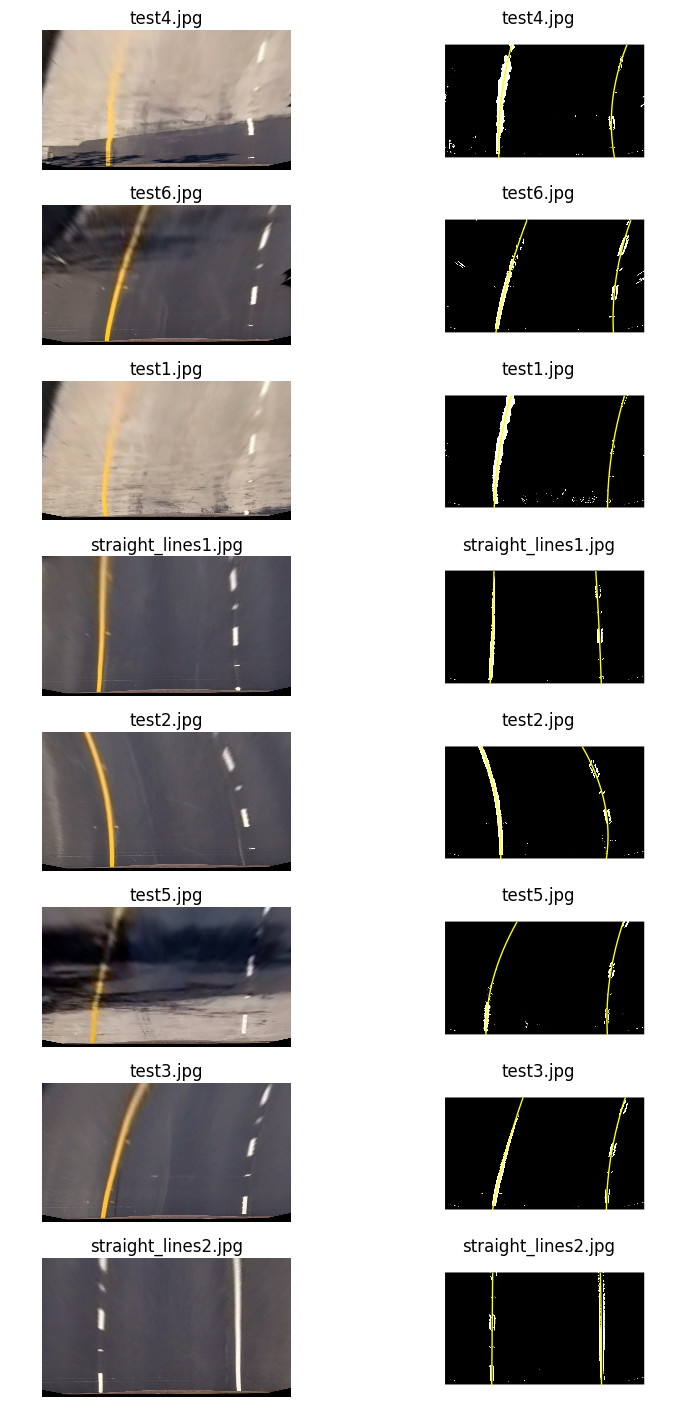

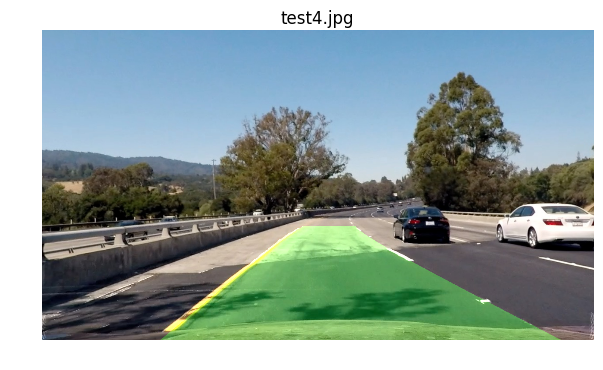

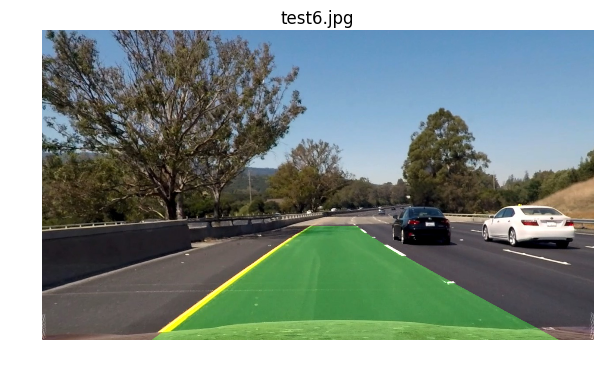

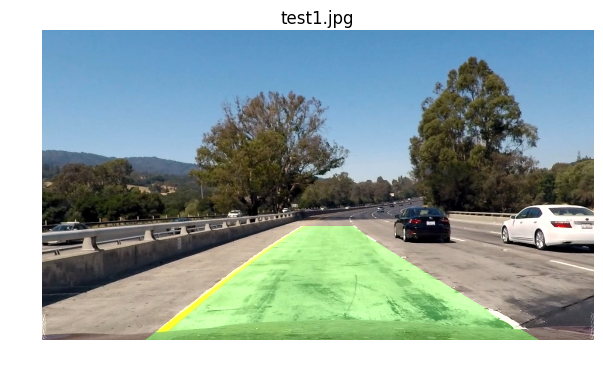

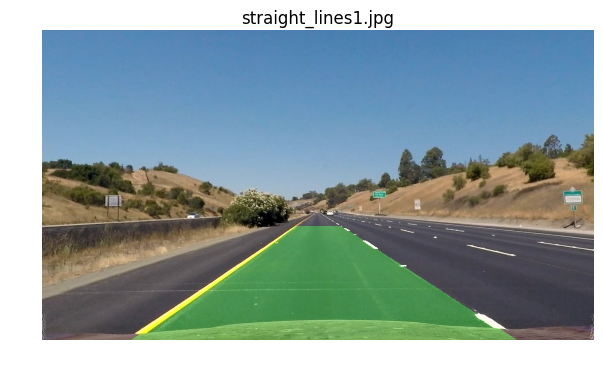

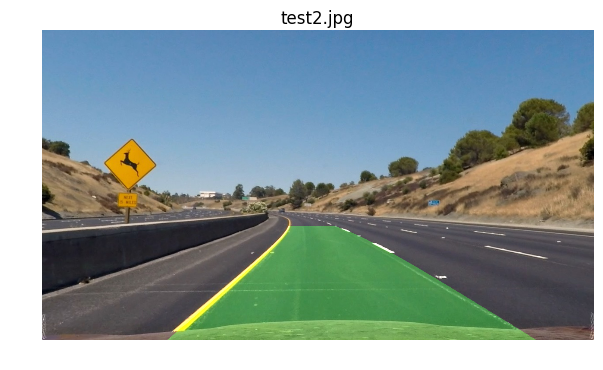

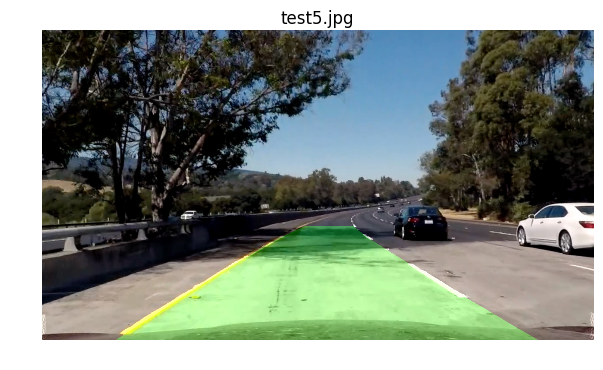

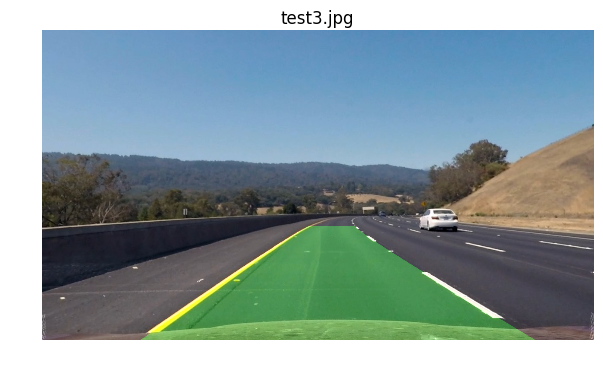

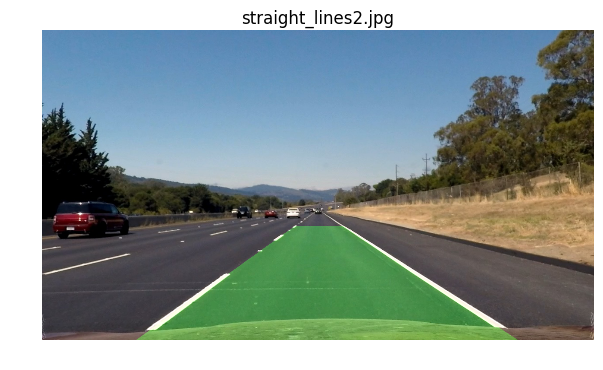

In [11]:
def plot_lane_lines(axis, image, fit_left_x, fit_right_x, title_text):
    fity = np.linspace(0, image.shape[0]-1, image.shape[0] )
    axis.imshow(image)
    axis.plot(fit_leftx, fity, color='yellow')
    axis.plot(fit_rightx, fity, color='yellow')
    axis.axis('off')
    axis.set_title(title_text)

index = 0
plt.figure(figsize=(8, 18))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.5, hspace=0.05)

gray_thresh = (36, 255)
s_thresh = (125, 255)
l_thresh = (120, 235)

for file in os.listdir('../test_images/'):
    file_with_full_path = '../test_images/' + file
    fit_leftx, fit_rightx, src_image_copy, src_warped, binary_warped = \
                 extract_laneline_data(file_with_full_path, gray_thresh, s_thresh,l_thresh)
    #draw_lane_lines(binary_warped, fit_leftx, fit_rightx)
    
    ax1 = plt.subplot(gs[index])
    ax1.axis('off')
    ax1.set_title(file)
    ax1.imshow(cv2.cvtColor(src_warped, cv2.COLOR_BGR2RGB))
    
    index += 1
    
    ax2 = plt.subplot(gs[index])
    plot_lane_lines(ax2, binary_warped, fit_leftx, fit_rightx, file)
    
    index += 1


def fill_lane_lines(image, fit_leftx, fit_rightx):
    copy_image = np.copy(image)
    fity = np.linspace(0, copy_image.shape[0]-1, copy_image.shape[0] )
    
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(copy_image, np.int_([pts]), (0,255, 0))
    
    return copy_image


def merge_images(binary_img, src_image):
    copy_binary = np.copy(binary_img)
    copy_src_img = np.copy(src_image)
    
    copy_binary_pers = perspective.inverse_transform(copy_binary)
    result = cv2.addWeighted(copy_src_img, 1, copy_binary_pers, 0.3, 0)
    
    return result
    #image = mpimg.imread('../output_images/undistorted_test_images/test5.jpg')
    

for file in os.listdir('../test_images/'):
    fit_leftx, fit_rightx, src_image_copy, src_wraped, binary_warped =  \
      extract_laneline_data('../test_images/' + file, gray_thresh, s_thresh,l_thresh)
    
    filled_img = fill_lane_lines(binary_warped, fit_leftx, fit_rightx)
    merger_img = merge_images(filled_img, src_image_copy)

    plt.figure(figsize=(8, 4))
    plt.axis('off')
    plt.title(file)
    plt.imshow(cv2.cvtColor(merger_img, cv2.COLOR_BGR2RGB))
    
    plt.show()

In [12]:
def test(image):
    pass
    

In [13]:
window_img = np.zeros_like(undistorted)

left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
left_line_pts = np.hstack((left_line_window1 + 70, left_line_window2 - 70))
right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_image, 3, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

NameError: name 'margin' is not defined